# Project - Korea President별 인용구 분석

김영삼 대통령, 김대중 대통령, 노무현 대통령, 이명박 대통령의 인용구 분석을 통하여 대통령을 예측하는 분석 진행

---

### Import

In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")
from konlpy.tag import Twitter
import lightgbm as lgb
from sklearn.metrics import *
import requests
import pandas as pd 
from bs4 import BeautifulSoup
import glob
import re

---

### Data Setting

In [2]:
def data_setting():
    ys = pd.read_csv("1. 김영삼 대통령 재임기간 인용문 추출.csv", encoding="cp949")
    dj = pd.read_csv("2. 김대중 대통령 재임기간 인용문 추출.csv", encoding="cp949")
    no = pd.read_csv("3. 노무현 대통령 재임기간 인용문 추출.csv", encoding="cp949")
    mb = pd.read_csv("4. 이명박 대통령 재임기간 인용문 추출.csv", encoding="cp949")
    
    ys['category'] = 1
    dj['category'] = 2
    no['category'] = 3
    mb['category'] = 4
    
    total = pd.concat([ys, dj, no, mb]).reset_index(drop=True)
    
    total = total.dropna()
    
    def remove(word):
        word = re.sub("\n", " ", word)
        return word

    total['인용구'] = total['인용구'].apply(remove)
    
    return total

total = data_setting()

In [3]:
total.tail()

,날짜,언론사,뉴스ID,인용구,정보원,category
49448,2008-02-01,세계일보,1.1007e+06,화합 속에 변화를 추구하고 선진화를 바탕으로 새 발전 체제를 열겠다,이명박 대통령,4
49449,2008-02-01,경향신문,1.1001e+06,미국의 루스벨트 대통령도 댐을 짓고 해서 경기를 부양한 예가 있어 그런 점에서 (대...,이명박 대통령,4
49450,2008-02-01,한겨레,1.101e+06,일주일 내내 청와대에 있으려고 생각하지 않는다,이명박 대통령,4
49451,2008-02-01,한국일보,1.1011e+06,저는 (취임 이후) 일주일 내내 청와대에 있으려고 생각하지 않는다 금요일 오후 되면...,이명박 대통령,4
49452,2008-02-01,한겨레,1.101e+06,비영어권 나라에서는 영어를 잘 쓰는 나라들이 못 쓰는 나라보다 훨씬 잘 산다 인수위...,이명박 대통령,4


In [4]:
total['category'].value_counts()

4    22512
3    14366
2     8643
1     3819
Name: category, dtype: int64

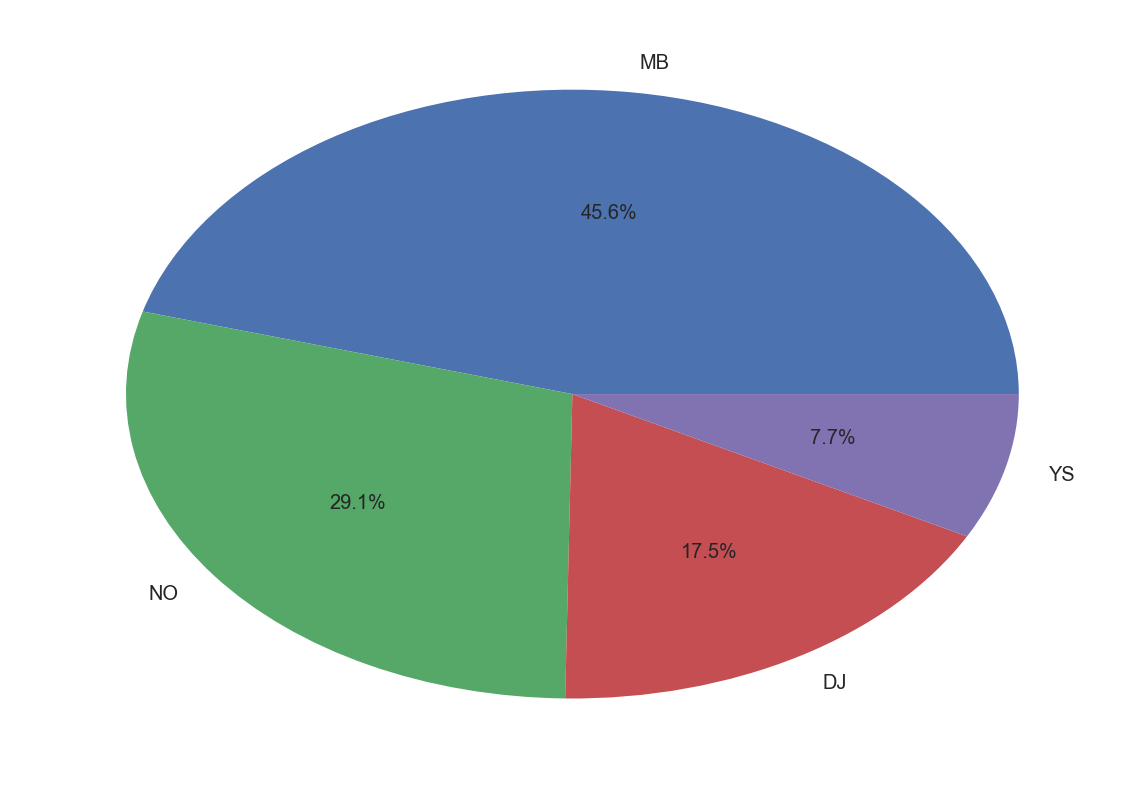

In [8]:
# 구성 비율 체크 (Pie chart)

total_v = total['category'].value_counts()
fig = plt.figure(figsize = (10,7))
labels = ['MB','NO','DJ','YS']
plt.pie(total_v, labels=labels ,autopct='%1.1f%%')
plt.show()

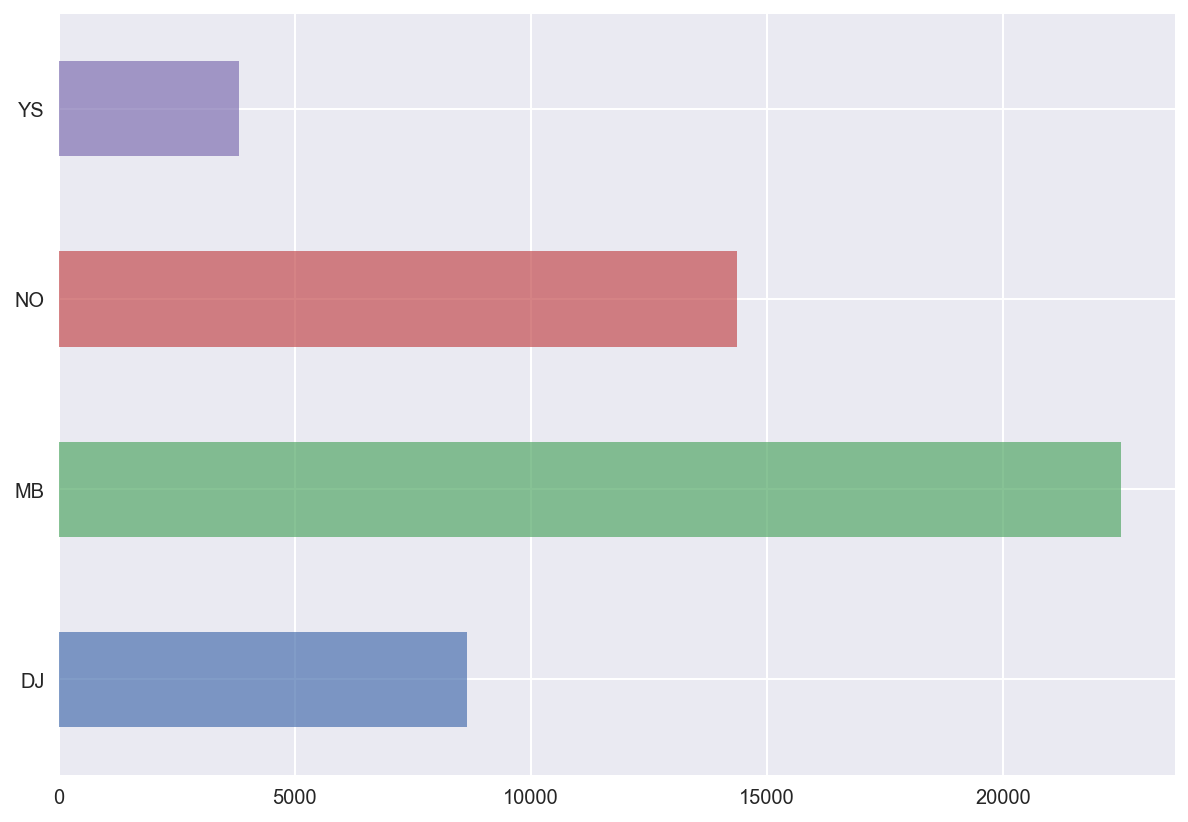

In [9]:
# 구성 비율 체크 (Bar chart)

total_v_s = pd.Series({'MB':22512,'NO':14366,'DJ':8643,'YS':3819})
fig = plt.figure(figsize = (10,7))
total_v_s.plot(kind="barh", align='center', alpha=0.7)
plt.show()

### 1. 분석(원자료 활용)

In [5]:
from konlpy.tag import Twitter
from konlpy.tag import *
hannanum = Hannanum()
kkma = Kkma()
twitter = Twitter()

def tokenize_pos(doc):
    return ['/'.join(t) for t in twitter.pos(doc)]

In [6]:
# Pipeline 구축

clf = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize_pos, ngram_range=(1,3))), 
    ("clf", MultinomialNB(alpha=0.01))
])

In [7]:
# 데이터 split

X_train, X_test, y_train, y_test = train_test_split(total['인용구'], total['정보원'], \
                                                    test_size=0.4, random_state=0)

len(X_train),len(X_test),len(y_train),len(y_test)

(29604, 19736, 29604, 19736)

Train 

Train confusion_matrix 

[[2 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 1]] 


Train classification_report 

                   precision    recall  f1-score   support

          CEO 이명박       1.00      1.00      1.00         2
      간담회 노무현 대통령       1.00      1.00      1.00         1
국민회의 김대중 (金大中) 후보       1.00      1.00      1.00         1
      국민회의 김대중 총재       1.00      1.00      1.00         5
  국민회의 김대중 총재의 비서       1.00      1.00      1.00         1
      국민회의 김대중 후보       1.00      1.00      1.00         1
         국회의원 노무현       1.00      1.00      1.00         1
    김대중 (金大中) 대통령       1.00      0.96      0.98        28
     김대중 (金大中)대통령       1.00      1.00      1.00      2341
      김대중 (金大中)총재       1.00      1.00      1.00         2
  김대중 (金大中)평민당 총재       1.00      1.00      1.00         2
      김대중 (金大中)후보       1.00      0.50      0.67         2
     김대중 (金大中)대통령       0.99      0.98      0.

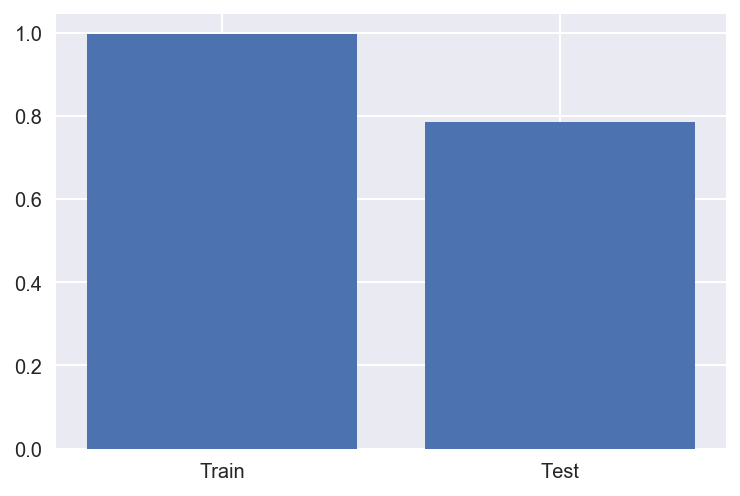

In [8]:
# def Korea_President():

model_o  = clf.fit(X_train, y_train)

y_pred  = model_o.predict(X_train)

print("Train", "\n")
print("Train confusion_matrix", "\n")
print(confusion_matrix(y_train, y_pred), "\n\n")
print("Train classification_report", "\n")
print(classification_report(y_train, y_pred), "\n\n")
print("Train accuracy_score", "\n")
print(round(accuracy_score(y_train, y_pred), 2), "\n\n")

print("=====================================================" , "\n\n")

y_pred_t = model_o.predict(X_test)

print("Test", "\n")
print("Test confusion_matrix", "\n")
print(confusion_matrix(y_test, y_pred_t), "\n\n")
print("Test classification_report", "\n")
print(classification_report(y_test, y_pred_t), "\n\n")
print("Test accuracy_score", "\n")
print(round(accuracy_score(y_test, y_pred_t), 2), "\n\n")

x="Train","Test"
y=accuracy_score(y_train, y_pred), accuracy_score(y_test, y_pred_t)
plt.bar(x,y)
plt.show()

### 문구 Test

In [35]:
X__=pd.Series("댐")

y_pred_t_o = model_o.predict_proba(X__)
y_pred_o = model_o.predict(X__)

print(y_pred_t_o)
print(y_pred_o)

[[7.01344316e-06 3.50719603e-06 3.50969312e-06 1.75175568e-05
  3.50897364e-06 3.50952022e-06 3.51149320e-06 9.66204437e-05
  1.42890696e-01 7.01776717e-06 7.00995379e-06 7.01870242e-06
  5.51639313e-02 3.51139133e-06 3.51163500e-06 1.05144334e-05
  1.40123379e-05 3.83022789e-05 1.87027578e-01 1.48863532e-04
  3.51080672e-06 3.51130636e-06 3.51162597e-06 3.51060881e-06
  2.44328009e-05 1.32695042e-04 6.95267987e-05 2.65738109e-03
  7.01770729e-06 7.01455031e-06 3.51091002e-06 7.01527907e-06
  1.05174580e-05 3.50962140e-06 7.01770531e-06 3.51083370e-06
  3.51099467e-06 3.51097433e-06 4.88380072e-05 3.51031583e-06
  3.50834876e-06 3.50974540e-06 1.05007997e-05 1.22909253e-04
  3.50839786e-06 3.51082928e-06 2.17613564e-01 3.51000656e-06
  5.89924638e-05 3.51112970e-06 3.49337230e-05 3.50909589e-06
  3.50930467e-06 3.51131662e-06 7.01721002e-06 3.51110357e-06
  3.51187144e-06 3.51055882e-06 3.51040429e-06 3.51072714e-06
  2.02531601e-04 3.50972263e-06 3.50985199e-06 7.01553718e-06
  7.0166

In [42]:
X__=pd.Series(str(input("insert 1number : ")))

y_pred_t_o = model_o.predict_proba(X__)
y_pred_o = model_o.predict(X__)

print(y_pred_t_o)
print(y_pred_o)

insert 1number : 강
[[8.90713474e-07 4.45416993e-07 4.45734125e-07 2.22474518e-06
  4.45642751e-07 4.45712166e-07 4.45962737e-07 1.22708817e-05
  6.29765867e-02 8.91262626e-07 8.90270321e-07 8.91381405e-07
  4.48423154e-03 4.45949799e-07 4.45980745e-07 1.33534232e-06
  1.77957928e-06 4.86442323e-06 4.27033186e-02 1.68631604e-04
  4.45875553e-07 4.45939007e-07 4.45979598e-07 4.45850419e-07
  3.10298729e-06 2.58928383e-04 8.82996482e-06 6.46200810e-02
  8.91255022e-07 8.90854083e-07 4.45888673e-07 8.90946636e-07
  1.33572645e-06 4.45725017e-07 8.91254771e-07 4.45878980e-07
  4.45899423e-07 4.45896840e-07 6.20247003e-06 4.45813209e-07
  4.45563390e-07 4.45740765e-07 1.33361083e-06 1.56095837e-05
  4.45569626e-07 4.45878419e-07 1.83383053e-01 4.45773932e-07
  7.49209499e-06 4.45916572e-07 4.43661367e-06 4.45658276e-07
  4.45684792e-07 4.45940311e-07 8.91191869e-07 4.45913253e-07
  4.46010773e-07 4.45844070e-07 4.45824444e-07 4.45865446e-07
  1.41957306e-04 4.45737873e-07 4.45754302e-07 8.90

---

### 대통령 category (1:김영삼 대통령, 2:김대중 대통령, 3:노무현 대통령, 4:이명박 대통령)

In [16]:
from konlpy.tag import Twitter
from konlpy.tag import *
hannanum = Hannanum()
kkma = Kkma()
twitter = Twitter()

def tokenize_pos(doc):
    return ['/'.join(t) for t in twitter.pos(doc)]

In [17]:
# Pipeline 구축

clf = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize_pos, ngram_range=(1,3))), 
    ("clf", MultinomialNB(alpha=0.01))
])

In [18]:
# 데이터 split

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(total['인용구'], total['category'], \
                                                    test_size=0.4, random_state=0)

len(X_train_c),len(X_test_c),len(y_train_c),len(y_test_c)

(29604, 19736, 29604, 19736)

Train 

Train confusion_matrix 

[[ 2289     2     3     4]
 [    1  5165     2    10]
 [    3     1  8642    10]
 [    2     1    13 13456]] 


Train classification_report 

             precision    recall  f1-score   support

          1       1.00      1.00      1.00      2298
          2       1.00      1.00      1.00      5178
          3       1.00      1.00      1.00      8656
          4       1.00      1.00      1.00     13472

avg / total       1.00      1.00      1.00     29604
 


Train accuracy_score 

1.0 




Test 

Test confusion_matrix 

[[ 969  216  180  156]
 [  55 2658  391  361]
 [  22  242 4848  598]
 [  32  164  524 8320]] 


Test classification_report 

             precision    recall  f1-score   support

          1       0.90      0.64      0.75      1521
          2       0.81      0.77      0.79      3465
          3       0.82      0.85      0.83      5710
          4       0.88      0.92      0.90      9040

avg / total       0.85      0.85      0.85    

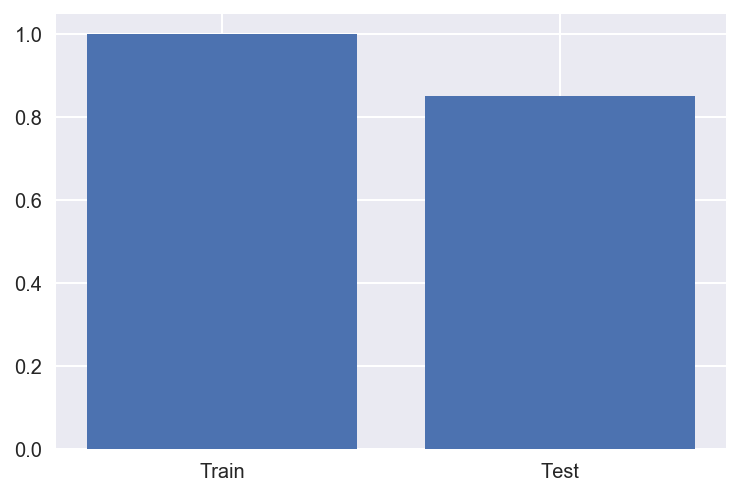

In [19]:
# def Korea_President():

model  = clf.fit(X_train_c, y_train_c)

y_pred  = model.predict(X_train_c)

print("Train", "\n")
print("Train confusion_matrix", "\n")
print(confusion_matrix(y_train_c, y_pred), "\n\n")
print("Train classification_report", "\n")
print(classification_report(y_train_c, y_pred), "\n\n")
print("Train accuracy_score", "\n")
print(round(accuracy_score(y_train_c, y_pred), 2), "\n\n")

print("=====================================================" , "\n\n")

y_pred_t = model.predict(X_test_c)

print("Test", "\n")
print("Test confusion_matrix", "\n")
print(confusion_matrix(y_test_c, y_pred_t), "\n\n")
print("Test classification_report", "\n")
print(classification_report(y_test_c, y_pred_t), "\n\n")
print("Test accuracy_score", "\n")
print(round(accuracy_score(y_test_c, y_pred_t), 2), "\n\n")

x="Train","Test"
y=accuracy_score(y_train_c, y_pred), accuracy_score(y_test_c, y_pred_t)
plt.bar(x,y)
plt.show()

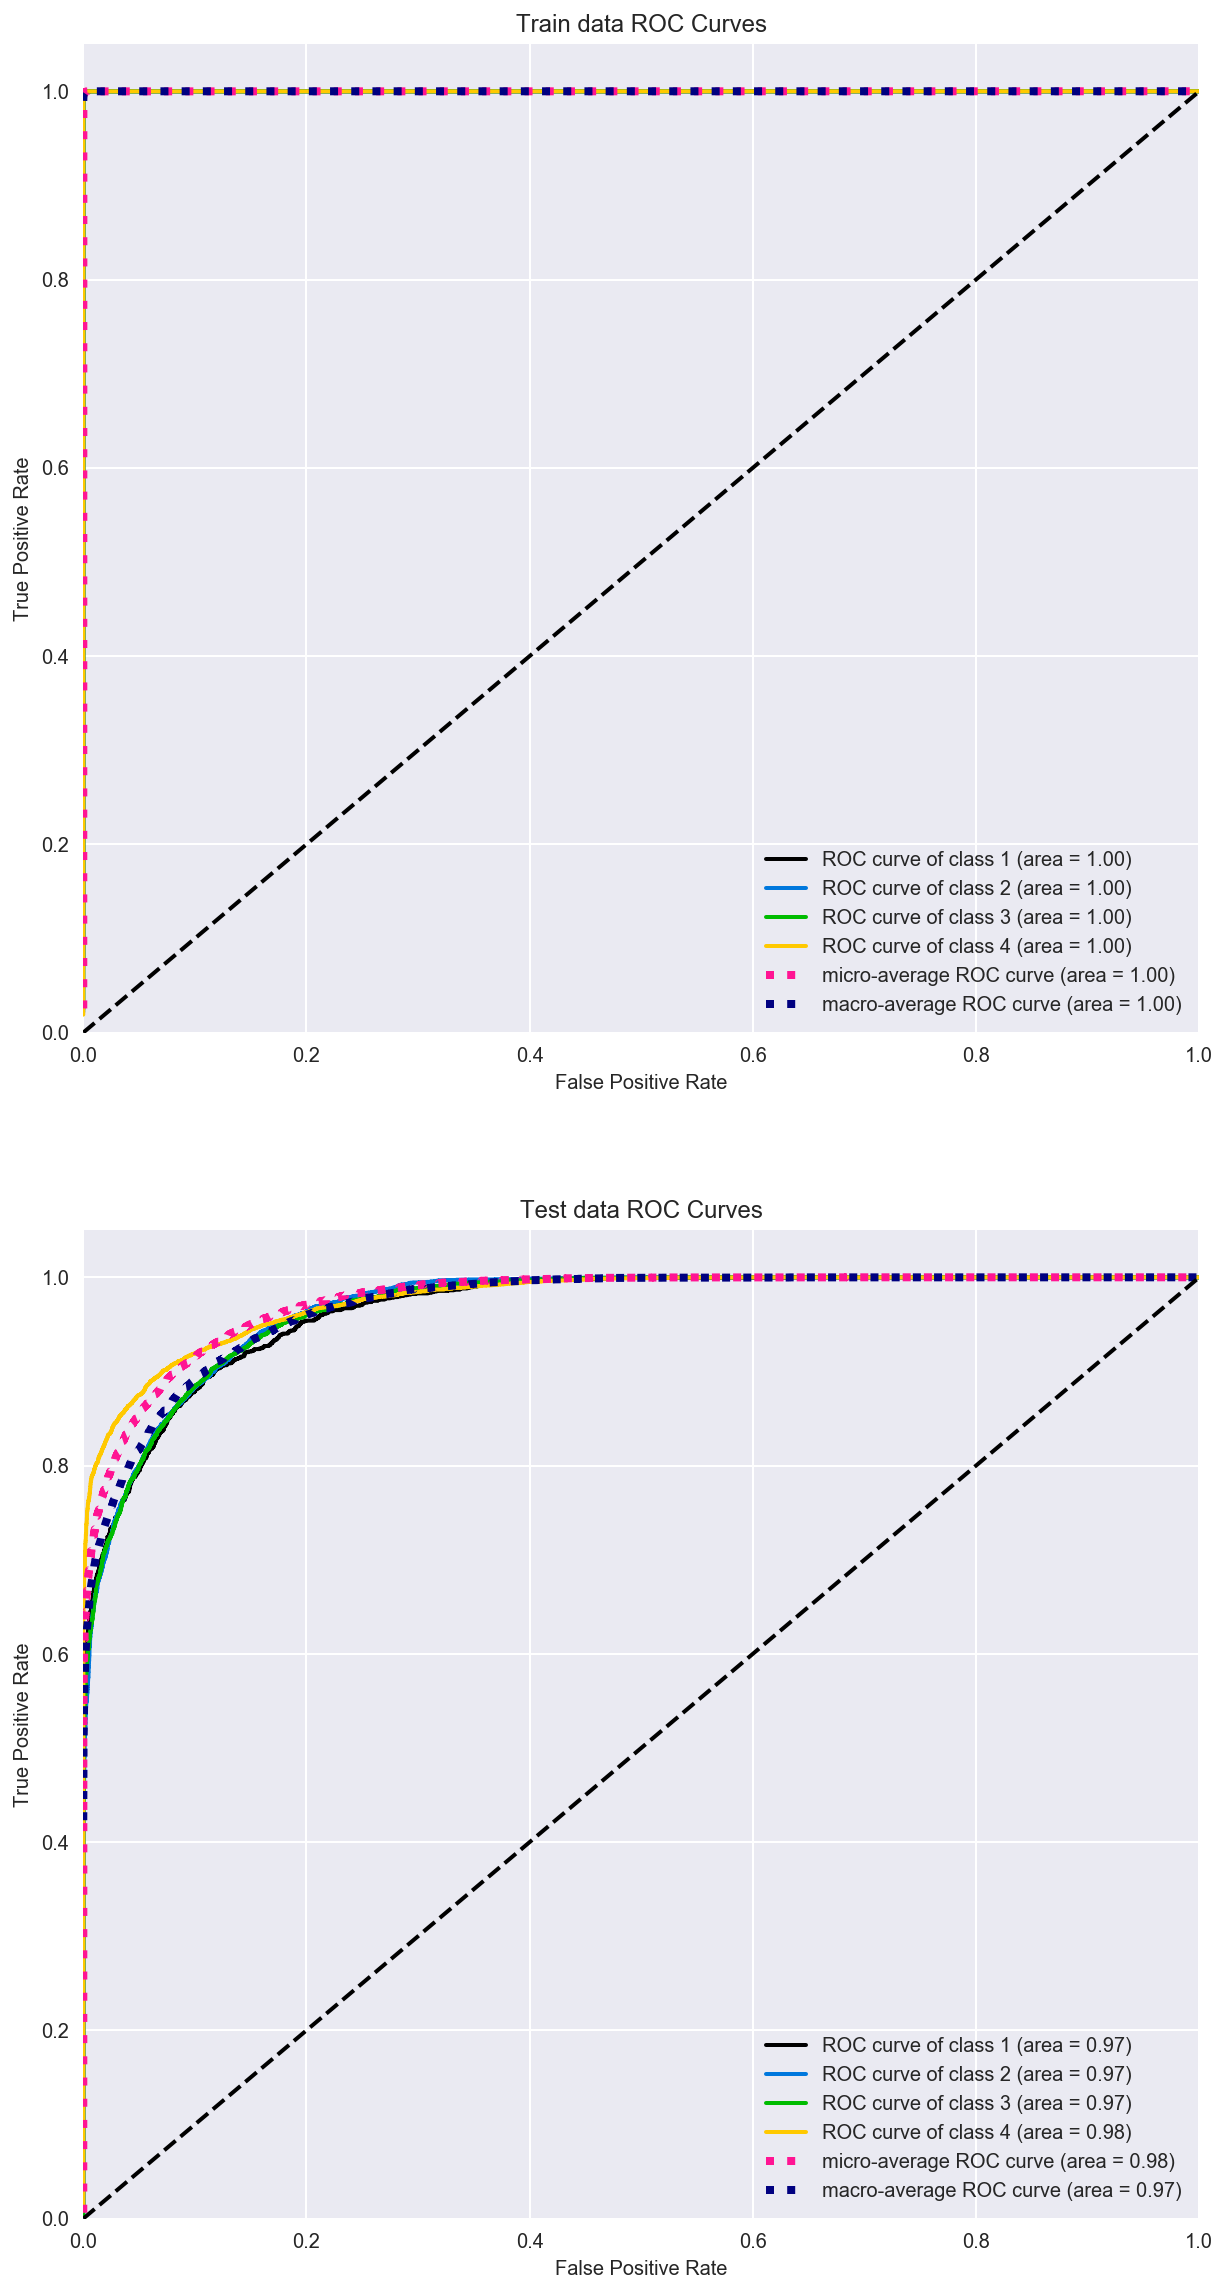

In [20]:
# ROC 민감도 체크

import scikitplot as skplt

fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

y_probas = model.predict_proba(X_train_c)
y_probas_T = model.predict_proba(X_test_c)

skplt.metrics.plot_roc_curve(y_train_c, y_probas, ax=ax1, title='Train data ROC Curves')

skplt.metrics.plot_roc_curve(y_test_c, y_probas_T, ax=ax2, title='Test data ROC Curves')

plt.show()

### 문구 Test (1:김영삼 대통령, 2:김대중 대통령, 3:노무현 대통령, 4:이명박 대통령)

In [9]:
X_=pd.Series("개헌")

y_pred_t = model.predict_proba(X_)
y_pred = model.predict(X_)

print(y_pred_t)
print(y_pred)

[[0.0618558  0.12580478 0.58182646 0.23051296]]
[3]


In [30]:
X_=pd.Series(str(input("insert 1number : ")))

y_pred_t = model.predict_proba(X_)
y_pred = model.predict(X_)

print(y_pred_t)
print(y_pred)

insert 1number : 평양
[[0.02325863 0.58644845 0.2564301  0.13386282]]
[2]


---

**Korea_President_Analysis 분석 결과**
 - 이번분석은 원 data의 카테고리에 따른 분석보다는 새로운 카테고리를 지정하여 분석 결과가 더 좋은 performance가 나오는것을 알 수 있다.
 - 이에 새로운 카테고리의 전처리 부분이 중요한 작업이었다.

**이번 분석을 통하여 각 대통령들의 관심사를 알수있었으며, 국민들이 관심있는 문구 또는 주제를 많이 다루고 말했던 대통령을 확률적으로 예측할수있다.**

**Copyright ⓒ 2018 by ParkSungho All Pictures cannot be copied without permission**